In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


In [4]:
batch_size = 64
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 30
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=50

In [5]:
test_datagen = ImageDataGenerator( rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory('../input/gender-dataset/Dataset/Train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )     

validation_generator =  test_datagen.flow_from_directory( '../input/gender-dataset/Dataset/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [23]:
base_model = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights="imagenet")
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [25]:
# Freezing Layers

for layer in base_model.layers[:fre]:
    layer.trainable=False

In [27]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))



# Add new layers
model.add(Flatten())
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(E, activation='sigmoid'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_22 (Dropout)         (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 2, 512)         2359808   
_________________________________________________________________
batch_normalization_11 (Batc (None, 2, 2, 512)         2048      
_________________________________________________________________
dropout_23 (Dropout)         (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 128)         589952    
_________________________________________________________________
batch_normalization_12 (Batc (None, 2, 2, 128)        

In [29]:
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

In [31]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=verbose, patience=patience)

In [33]:
%time
hist = model.fit_generator(generator=train_generator,
                           validation_data=validation_generator,
                           steps_per_epoch=steps_per_epoch,
                           validation_steps=validation_steps,
                           epochs=10,
                           callbacks=[lrd, mcp, es])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Epoch 1/10
256/256 [==============================] - 79s 307ms/step - loss: 0.1600 - accuracy: 0.9418 - val_loss: 0.3419 - val_accuracy: 0.9323
Epoch 2/10
256/256 [==============================] - 77s 302ms/step - loss: 0.1482 - accuracy: 0.9442 - val_loss: 0.2711 - val_accuracy: 0.9130
Epoch 3/10
256/256 [==============================] - 76s 297ms/step - loss: 0.1375 - accuracy: 0.9473 - val_loss: 0.2394 - val_accuracy: 0.9200
Epoch 4/10
256/256 [==============================] - 76s 296ms/step - loss: 0.1305 - accuracy: 0.9491 - val_loss: 0.2866 - val_accuracy: 0.9207
Epoch 5/10
256/256 [==============================] - 78s 303ms/step - loss: 0.1339 - accuracy: 0.9470 - val_loss: 0.1412 - val_accuracy: 0.9438
Epoch 6/10
256/256 [==============================] - 76s 297ms/step - loss: 0.1243 - accuracy: 0.9553 - val_loss: 0.1567 - val_accuracy: 0.9562
Epoch 7/10
256/256 [==============================] - 81s 317ms/st

In [35]:
model.save("/kaggle/working/GenderEstimation_VGG16.h5")

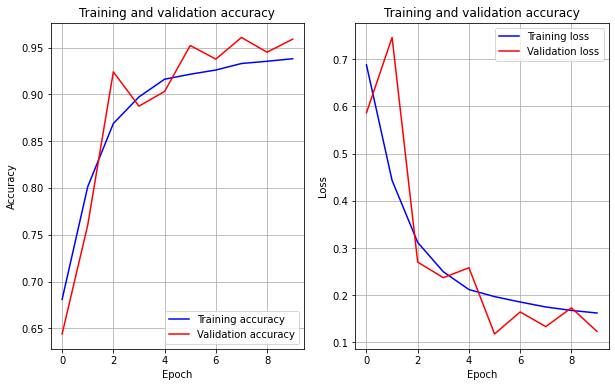

In [12]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize = (10,6))
plt.subplot(121)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid("True")

plt.subplot(122)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.grid("True")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()



[1.]
This is a male


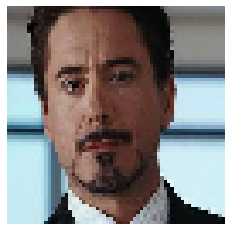

In [14]:
import numpy as np

from keras.preprocessing import image
#  images test 2
path_testmodel = "/kaggle/input/testmodel/test2.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]>0.5:
    print("This is a male")
else:
    print( "This is a female")
plt.imshow(imge)
plt.axis("off")
plt.show()

[0.]
This is a female


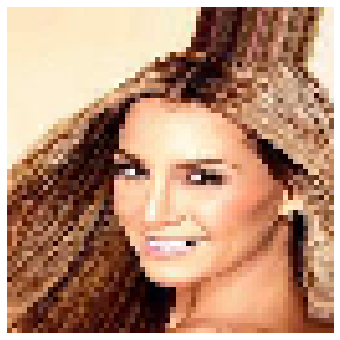

In [36]:
import numpy as np

from keras.preprocessing import image
#  images test 2
path_testmodel = "/kaggle/input/gender-dataset/Dataset/Train/Female/000001.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]>0.5:
    print("This is a male")
else:
    print( "This is a female")
    
plt.figure(figsize = (10, 6))
plt.imshow(imge)
plt.axis("off")
plt.show()

# Evaluation 

Found 20001 images belonging to 2 classes.
313/313 [==============================] - 66s 209ms/step
Accuracy: 0.9653
Precision: 0.9521
Recall: 0.9665
F1-score: 0.9593
Confusion Matrix:
[[11131   411]
 [  283  8176]]
Classification Report:
              precision    recall  f1-score   support

      Female       0.98      0.96      0.97     11542
        Male       0.95      0.97      0.96      8459

    accuracy                           0.97     20001
   macro avg       0.96      0.97      0.96     20001
weighted avg       0.97      0.97      0.97     20001



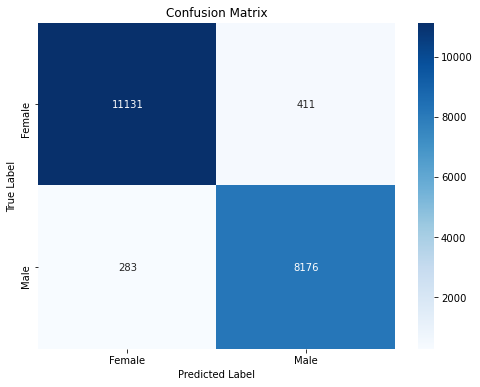

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Load the trained model
model = load_model("/kaggle/working/GenderEstimation_VGG16.h5")

# Prepare test data generator
test_generator = test_datagen.flow_from_directory(
    '../input/gender-dataset/Dataset/Test',
    batch_size=batch_size,
    class_mode='binary',
    seed=seed,
    target_size=target_size,
    shuffle=False)  # Do not shuffle to maintain order for metrics calculation

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary values (0 or 1)
y_pred = (predictions > 0.5).astype(int)

# Get ground truth
y_true = test_generator.classes

# Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Resnet50

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Load the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the initial layers of ResNet50
for layer in base_model.layers[:fre]:
    layer.trainable = False

# Building the Model
resnet_model = Sequential()
resnet_model.add(base_model)  # Add the pre-trained ResNet50 model
resnet_model.add(layers.Dropout(0.2))

# Add Conv2D, BatchNormalization, and Dropout layers
resnet_model.add(Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.1))

resnet_model.add(Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.1))


resnet_model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.1))

# Add Fully Connected (Dense) Layers
resnet_model.add(Flatten())
resnet_model.add(Dense(FC, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(FC, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(FC, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(E, activation='sigmoid'))  # Binary classification

# Model Summary
resnet_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 2, 2048)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 512)         9437696   
_________________________________________________________________
batch_normalization_3 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 256)         1179904   
_________________________________________________________________
batch_normalization_4 (Batch (None, 2, 2, 256)        

In [9]:
# Compile the model
resnet_model.compile(
    optimizer=Adam(learning_rate=adam),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [10]:
pat = 8
# Define callbacks
reduce_lr_resnet = ReduceLROnPlateau(
    monitor='val_loss', factor=factor, patience=pat, verbose=verbose, min_lr=min_lr
)
checkpoint_resnet = ModelCheckpoint('resnet_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping_resnet = EarlyStopping(monitor='val_loss', patience=patience, verbose=verbose)

# Train the model

In [11]:
# Ensure 'epochs' is an integer
epochs = 10  # Set the number of epochs explicitly

# Fit the model
history_resnet = resnet_model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,  # Now `epochs` is an integer
    callbacks=[reduce_lr_resnet, checkpoint_resnet, early_stopping_resnet]
)


Epoch 1/10
256/256 [==============================] - 177s 693ms/step - loss: 0.6677 - accuracy: 0.6322 - val_loss: 1.3560 - val_accuracy: 0.4593
Epoch 2/10
256/256 [==============================] - 136s 530ms/step - loss: 0.6060 - accuracy: 0.6732 - val_loss: 0.6144 - val_accuracy: 0.6928
Epoch 3/10
256/256 [==============================] - 135s 526ms/step - loss: 0.5810 - accuracy: 0.6944 - val_loss: 1.0728 - val_accuracy: 0.4951
Epoch 4/10
256/256 [==============================] - 114s 445ms/step - loss: 0.5764 - accuracy: 0.6974 - val_loss: 1.0526 - val_accuracy: 0.4985
Epoch 5/10
256/256 [==============================] - 127s 495ms/step - loss: 0.5637 - accuracy: 0.7079 - val_loss: 0.7042 - val_accuracy: 0.5353
Epoch 6/10
256/256 [==============================] - 108s 423ms/step - loss: 0.5702 - accuracy: 0.7045 - val_loss: 0.7384 - val_accuracy: 0.4861
Epoch 7/10
256/256 [==============================] - 109s 424ms/step - loss: 0.5496 - accuracy: 0.7186 - val_loss: 0.5949 -

In [12]:
# Save the model
resnet_model.save("/kaggle/working/GenderEstimation_ResNet50.h5")

[0.7764352]
This is a male


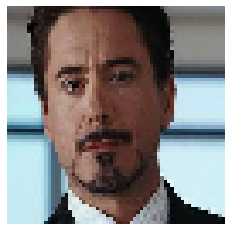

In [14]:
import numpy as np

from keras.preprocessing import image
#  images test 2
path_testmodel = "/kaggle/input/testmodel/test2.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = resnet_model.predict(images, batch_size=1)
print(classes[0])
if classes[0]>0.5:
    print("This is a male")
else:
    print( "This is a female")
plt.imshow(imge)
plt.axis("off")
plt.show()

[0.2768983]
This is a female


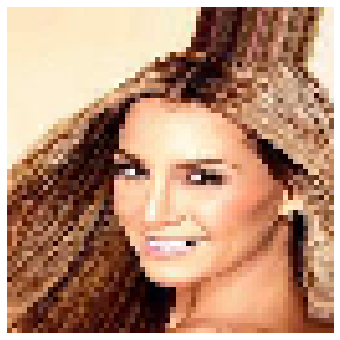

In [21]:
import numpy as np

from keras.preprocessing import image
#  images test 2
path_testmodel = "/kaggle/input/gender-dataset/Dataset/Train/Female/000001.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = resnet_model.predict(images, batch_size=1)
print(classes[0])
if classes[0]>0.5:
    print("This is a male")
else:
    print( "This is a female")
    
plt.figure(figsize = (10, 6))
plt.imshow(imge)
plt.axis("off")
plt.show()

Found 20001 images belonging to 2 classes.
313/313 [==============================] - 99s 315ms/step
Accuracy: 0.7862
Precision: 0.7953
Recall: 0.6658
F1-score: 0.7248
Confusion Matrix:
[[10092  1450]
 [ 2827  5632]]
Classification Report:
              precision    recall  f1-score   support

      Female       0.78      0.87      0.83     11542
        Male       0.80      0.67      0.72      8459

    accuracy                           0.79     20001
   macro avg       0.79      0.77      0.77     20001
weighted avg       0.79      0.79      0.78     20001



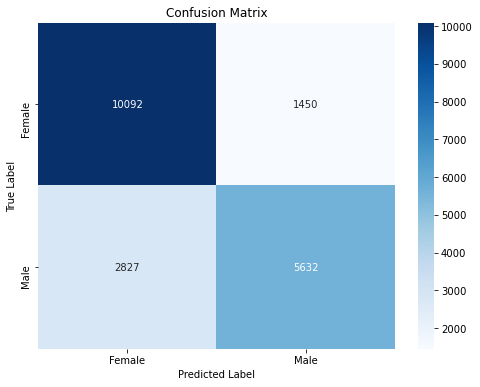

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Load the trained model
model = load_model("/kaggle/working/GenderEstimation_ResNet50.h5")

# Prepare test data generator
test_generator = test_datagen.flow_from_directory(
    '../input/gender-dataset/Dataset/Test',
    batch_size=batch_size,
    class_mode='binary',
    seed=seed,
    target_size=target_size,
    shuffle=False)  # Do not shuffle to maintain order for metrics calculation

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary values (0 or 1)
y_pred = (predictions > 0.5).astype(int)

# Get ground truth
y_true = test_generator.classes

# Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
